In [153]:
#!pip install control

In [154]:
import control as ct
import numpy as np
from sympy import symbols, nroots, I, Abs, arg
from sympy.functions.elementary.exponential import exp
from sympy.functions.elementary.complexes import re, im
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [176]:
# Set up flame transfer function
num = [-5,-3]
den = [10,5,4,9]
ftf = ct.tf(num, den)

# Set up frequencies omegas to be investigated
w_min = -2
w_max = 1
n = 1000
omegas = np.logspace(w_min, w_max, num = n)

# system transfer function
def FTF_time_delay(K, x_i, s, G = 1.5):
    tau = abs(x_i) / K  # convection delay (example)
    return G * exp(-1j * s * tau)

def ATF_single_mode(s, f0=200, zeta=0.02, G_a=1.0):
    omega0 = 2 * np.pi * f0
    return G_a / (1 - (s/omega0)**2 + 1j * 2*zeta*(s/omega0))

def sensitivity(K, x_i, omega, FTF_func, ATF_func):
    L = -FTF_func(K, x_i, I*omega) * ATF_single_mode(I*omega)
    return 1.0 / np.abs(1.0 + L), L

# omega = np.linspace(50, 500, 200)  # Hz, for instance
# S_vals = sensitivity(K=1.2, x_i=-2.0, omega=omegas, FTF_func=FTF_time_delay, ATF_func=ATF_single_mode)

# # Plot if desired
# # import matplotlib.pyplot as plt
# plt.plot(omega, S_vals)
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Sensitivity S")
# plt.show()

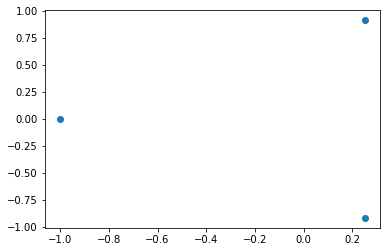

In [168]:
# Plot poles of ftf
poles = ct.poles(ftf)
plt.scatter([re(pole) for pole in poles], [im(pole) for pole in poles])

0

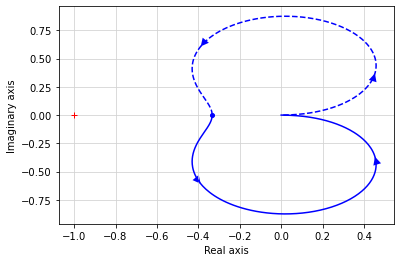

In [157]:
ct.nyquist_plot(ftf, color='b')

[1.0495932305582276]


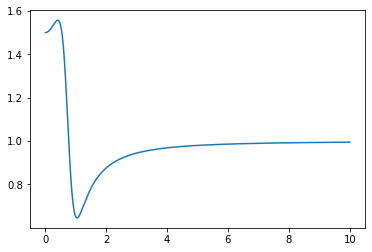

In [158]:
# Determine stability margin
mu = min([Abs(1+ftf(I*omega)) for omega in omegas])

# Plot sensitivity function
def S(omega):
    return 1/Abs(1+ftf(I*omega))

sensitivities = dict()
for omega in omegas:
    sensitivities[omega] = S(omega)

plt.plot(sensitivities.keys(), sensitivities.values())

# Determine critical frequencies
min_S = min(sensitivities.values())
omega_crit = list()
for omega in omegas:
    if sensitivities.get(omega) == min_S:
        omega_crit.append(omega)
print(omega_crit)

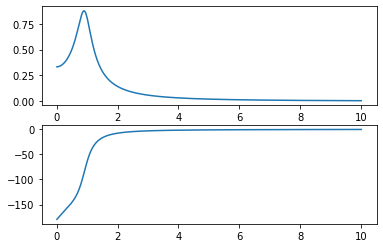

In [159]:
mag_resp, phase_resp, omega_resp = ct.frequency_response(ftf, omegas)

# Plot the absolute value and phase of the repsonse of th ftf
fig, ax = plt.subplots(2)
ax[0].plot(omegas, mag_resp)
ax[1].plot(omegas, phase_resp*180/3.14)

In [171]:
# Objective to optimize
def objective_for_optimizer(params, omega_crit, FTF_func, ATF_func,
                            instability_penalty=1e4, penalty_margin=-1.0):
    K, x_i = params
    # optional: limit K to positive if physics requires; here we allow any real but can penalize invalid ranges
    if K <= 0:
        # hard penalty for non-physical K (tunable)
        return 1e6 + 1e3 * abs(K)

    S_vals, L_vals = sensitivity(K, x_i, omega_crit[0], FTF_func, ATF_func)
    J = float(np.max(S_vals))

    # penalty: if for any tested freq Re(L) < penalty_margin (paper uses -1),
    # they add +1e4 to the cost. Ensures no loop around -1.
    if np.any(np.real(L_vals) < penalty_margin):
        J +=  instability_penalty # instability_penalty

    return J

def J(params):
    return objective_for_optimizer(params, omega_crit, FTF_time_delay, ATF_single_mode)

# Optimize settings
x0 = np.array([1.2, -2.0])
res = minimize(J, x0, method='Nelder-Mead', options={'maxiter': 200, 'xatol':1e-3, 'fatol':1e-3, 'disp': True})

print("Result:", res.x, "Objective value:", res.fun)

Optimization terminated successfully.
         Current function value: 0.400000
         Iterations: 30
         Function evaluations: 58
Result: [ 0.8489668  -2.54106582] Objective value: 0.39999983270616546


1.90400037361988


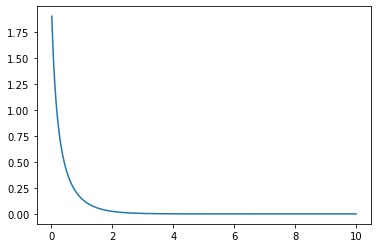

In [182]:
K = 1.2
x_i = -2.0
s_vals = [sensitivity(K, x_i, omega, FTF_time_delay, ATF_single_mode)[0] for omega in omegas]
print(max(s_vals))
plt.plot(omegas, s_vals)

1.83292497199092


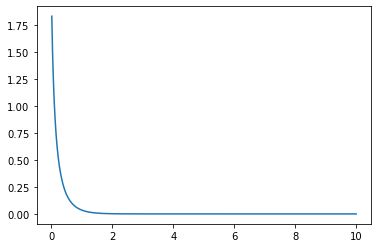

In [183]:
K = 0.8489668
x_i = -2.54106582
s_vals = [sensitivity(K, x_i, omega, FTF_time_delay, ATF_single_mode)[0] for omega in omegas]
print(max(s_vals))
plt.plot(omegas, s_vals)